In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4 as nc

import torch
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import transforms

from utils import *
from model import get_model

from sklearn.metrics import roc_auc_score, confusion_matrix
from torchvision.ops import sigmoid_focal_loss
from torch.nn.functional import binary_cross_entropy_with_logits

/home/dm4/anaconda3/envs/urp_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dm4/anaconda3/envs/urp_env/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
# ====== 실험 설정 ====== # 중요함
seeds = list(range(1, 6))

# 사용할 데이터 종류 설정, 단일 학습인지 멀티테스크인지 설정 (URP 에서 AAFOS FALSE 설정)
ASOS = True
AAFOS = False
assert ASOS or AAFOS, "At least one of ASOS or AAFOS must be True."

channels = '16ch' # '16ch' or 'ae304', 16ch일때 [16,512,512]
time_range = [-18, -15, -12]
resolution = '2km' # '1km':1024 or '2km':512
postfix = 'convlstm_prediction_384'

output_path = "results/"
output_path += 'asos_' if ASOS else ''
output_path += 'aafos_' if AAFOS else ''
output_path += channels + '_'
output_path += 'time' + str(time_range) + '_'
output_path += resolution
output_path += ('_' + postfix) if postfix != '' else postfix
print(f"Output path name: {output_path}")

# 기본 asos:aafos 비율 5:1
asos_aafos_ratio = 5.0
asos_weight = asos_aafos_ratio / (asos_aafos_ratio + 1.0 * AAFOS) if ASOS else 0.0
aafos_weight = 1.0 / (asos_aafos_ratio * ASOS + 1.0) if AAFOS else 0.0
print(f"ASOS weight: {asos_weight:.2f}, AAFOS weight: {aafos_weight:.2f}")

# 기타 ablation 설정
latlon = False

# 실험중인 설정들
central_patch = False
use_patch = False

#  ====== 채널 설정 ====== #
if channels == '16ch':
    channels_name = ['vi004','vi005','vi006','vi008','nr013','nr016','sw038','wv063','wv069','wv073','ir087','ir096','ir105','ir112','ir123','ir133'] # 시각화 용
    channels_calib = ['vi004','vi005','vi006','vi008','nr013','nr016','sw038','wv063','wv069','wv073','ir087','ir096','ir105','ir112','ir123','ir133']
    
    channels_mean = [1.1912e-01, 1.1464e-01, 1.0734e-01, 1.2504e-01, 5.4983e-02, 9.0381e-02,
                2.7813e+02, 2.3720e+02, 2.4464e+02, 2.5130e+02, 2.6948e+02, 2.4890e+02,
                2.7121e+02, 2.7071e+02, 2.6886e+02, 2.5737e+02]
    channels_std  = [0.1306,  0.1303,  0.1306,  0.1501,  0.0268,  0.0838, 15.8211,  6.1468,
                7.8054,  9.3251, 16.4265,  9.6150, 17.2518, 17.6064, 17.0090, 12.5026]

else:
    raise ValueError("Invalid channels.")


train_data_info_list = []
train_data_info_list.append({
    'label_type': 'asos', # 'asos' or 'aafos'
    'start_date_str': '20200101', #  라벨기준 일자. KST
    'end_date_str': '20230630',
    'hour_col_pairs': [(6,'AM')],
    'label_keys': ['93','108','112','119','131','133','136','143','146','156','177','102','104','115','138','152','155','159','165','168','169','184','189']
}) if ASOS else None

test_asos_data_info_list = [
    {
        'label_type': 'asos', # 'asos' or 'aafos'
        'start_date_str': '20230701', #  라벨기준 일자. KST
        'end_date_str': '20240630',
        'hour_col_pairs': [(6,'AM')],
        'label_keys': ['93','108','112','119','131','133','136','143','146','156','177','102','104','115','138','152','155','159','165','168','169','184','189']
    },
] if ASOS else None

origin_size = 900 if resolution == '2km' else 1800
image_size = 384  # 384x384 크기로 변경
patch_size = 384  # 패치 크기도 384로 변경

data_path = '/home/dm4/repo/data/kma_data/date_kst_URP_384/'

misc_channels = {
    'elevation':'elevation_1km_3600.npy',
    'vegetation':'vegetation_1km_3600.npy',
    'watermap':'watermap_1km_avg_3600.npy'
}
lat_lon_path = 'assets/gk2a_ami_ko010lc_latlon.nc'

# 학습과 관련된 설정! 변경 시 주의 요함
batch_size = 32
num_workers = 8

epochs = 25
lr = 1e-3
decay = [10, 20]
lr_decay = 0.1
weight_decay = 1e-5
threshold = [0.25]

# 자동으로 설정되는 값
asos_x_base, asos_y_base, asos_image_size = get_crop_base(image_size, label_type='asos')
aafos_x_base, aafos_y_base, aafos_image_size = get_crop_base(image_size, label_type='aafos')
aafos_x_base -= asos_x_base
aafos_y_base -= asos_y_base

total_channels = len(channels_name) * len(time_range) + len(misc_channels.keys())
total_channels += 2 if latlon else 0
print(total_channels)

Output path name: results/asos_16ch_time[-18, -15, -12]_2km_convlstm_prediction_384
ASOS weight: 1.00, AAFOS weight: 0.00
51


dict_keys([93, 108, 112, 119, 131, 133, 136, 143, 146, 156, 177, 102, 104, 115, 138, 152, 155, 159, 165, 168, 169, 184, 189])


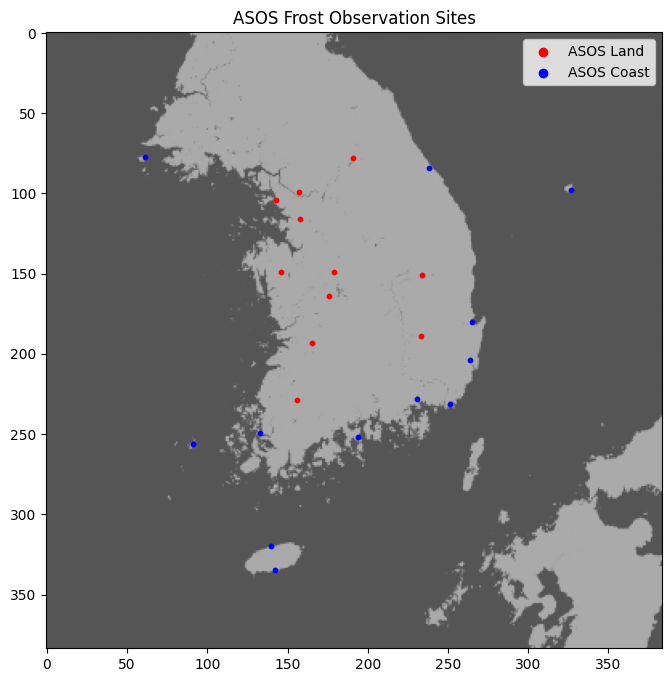

In [3]:
asos_land_map = {k: coord_to_map(*v, origin_size) for k, v in ASOS_LAND_COORD.items()}
asos_land_map = {k: (v[0]-asos_x_base, v[1]-asos_y_base) for k, v in asos_land_map.items()}
asos_coast_map = {k: coord_to_map(*v, origin_size) for k, v in ASOS_COAST_COORD.items()}
asos_coast_map = {k: (v[0]-asos_x_base, v[1]-asos_y_base) for k, v in asos_coast_map.items()}
asos_map_dict = {**asos_land_map, **asos_coast_map}
print(asos_map_dict.keys())

CROP_BASE = 64
image = np.load('assets/misc_channels/watermap_1km_avg_3600.npy', allow_pickle=True)
image = -image + 1.0
image = cv2.resize(image, (512, 512), interpolation=cv2.INTER_CUBIC)
image = image[CROP_BASE:CROP_BASE+asos_image_size, CROP_BASE:CROP_BASE+asos_image_size]  # 384x384로 crop


plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray', vmin=-1, vmax=2)

for k, v in asos_land_map.items():
    plt.scatter(v[0], v[1], c='r', marker='o', s=10)
for k, v in asos_coast_map.items():
    plt.scatter(v[0], v[1], c='b', marker='o', s=10)

    
plt.scatter([], [], c='r', marker='o', label='ASOS Land')
plt.scatter([], [], c='b', marker='o', label='ASOS Coast')

    
plt.title('ASOS Frost Observation Sites')
plt.legend()
plt.show()

In [4]:
if channels_mean is None:
    date_list = os.listdir(data_path)
    date_list = [date for date in date_list if '20200101' <= date < '20240101']

    npy_list = []
    for date in tqdm(date_list[::10]):
        for file in os.listdir(os.path.join(data_path, date)):
            if channels not in file:
                continue
            npy = np.load(os.path.join(data_path, date, file), allow_pickle=True).astype(np.float32) # (C, H, W)
            npy_list.append(npy)
    npy_array = np.stack(npy_list, axis=0)
    print(npy_array.shape) # (N, C, H, W)

    channels_mean = npy_array.mean(axis=(0,2,3)).tolist()
    channels_std = npy_array.std(axis=(0,2,3)).tolist()

channels_mean = channels_mean * len(time_range)
channels_std = channels_std * len(time_range)

print(channels_mean)
print(channels_std)

[0.11912, 0.11464, 0.10734, 0.12504, 0.054983, 0.090381, 278.13, 237.2, 244.64, 251.3, 269.48, 248.9, 271.21, 270.71, 268.86, 257.37, 0.11912, 0.11464, 0.10734, 0.12504, 0.054983, 0.090381, 278.13, 237.2, 244.64, 251.3, 269.48, 248.9, 271.21, 270.71, 268.86, 257.37, 0.11912, 0.11464, 0.10734, 0.12504, 0.054983, 0.090381, 278.13, 237.2, 244.64, 251.3, 269.48, 248.9, 271.21, 270.71, 268.86, 257.37]
[0.1306, 0.1303, 0.1306, 0.1501, 0.0268, 0.0838, 15.8211, 6.1468, 7.8054, 9.3251, 16.4265, 9.615, 17.2518, 17.6064, 17.009, 12.5026, 0.1306, 0.1303, 0.1306, 0.1501, 0.0268, 0.0838, 15.8211, 6.1468, 7.8054, 9.3251, 16.4265, 9.615, 17.2518, 17.6064, 17.009, 12.5026, 0.1306, 0.1303, 0.1306, 0.1501, 0.0268, 0.0838, 15.8211, 6.1468, 7.8054, 9.3251, 16.4265, 9.615, 17.2518, 17.6064, 17.009, 12.5026]


In [5]:
lat_lon_data = nc.Dataset(lat_lon_path)
lat = lat_lon_data['lat'][:].data
lon = lat_lon_data['lon'][:].data

lat = cv2.resize(lat, (origin_size, origin_size), interpolation=cv2.INTER_CUBIC)
lon = cv2.resize(lon, (origin_size, origin_size), interpolation=cv2.INTER_CUBIC)
print(lat.shape, lon.shape)

asos_lat = lat[asos_y_base:asos_y_base+asos_image_size, asos_x_base:asos_x_base+asos_image_size]
asos_lon = lon[asos_y_base:asos_y_base+asos_image_size, asos_x_base:asos_x_base+asos_image_size]
print(asos_lat.shape, asos_lon.shape)


lcc = ccrs.LambertConformal(central_longitude=126, central_latitude=38, standard_parallels = (30,60))
proj = ccrs.PlateCarree()

(900, 900) (900, 900)
(384, 384) (384, 384)


MISC images shape: torch.Size([3, 384, 384])
Total mean: [0.11912, 0.11464, 0.10734, 0.12504, 0.054983, 0.090381, 278.13, 237.2, 244.64, 251.3, 269.48, 248.9, 271.21, 270.71, 268.86, 257.37, 0.11912, 0.11464, 0.10734, 0.12504, 0.054983, 0.090381, 278.13, 237.2, 244.64, 251.3, 269.48, 248.9, 271.21, 270.71, 268.86, 257.37, 0.11912, 0.11464, 0.10734, 0.12504, 0.054983, 0.090381, 278.13, 237.2, 244.64, 251.3, 269.48, 248.9, 271.21, 270.71, 268.86, 257.37, 74.05298614501953, 0.149159774184227, 0.7218806743621826]
Total std: [0.1306, 0.1303, 0.1306, 0.1501, 0.0268, 0.0838, 15.8211, 6.1468, 7.8054, 9.3251, 16.4265, 9.615, 17.2518, 17.6064, 17.009, 12.5026, 0.1306, 0.1303, 0.1306, 0.1501, 0.0268, 0.0838, 15.8211, 6.1468, 7.8054, 9.3251, 16.4265, 9.615, 17.2518, 17.6064, 17.009, 12.5026, 0.1306, 0.1303, 0.1306, 0.1501, 0.0268, 0.0838, 15.8211, 6.1468, 7.8054, 9.3251, 16.4265, 9.615, 17.2518, 17.6064, 17.009, 12.5026, 178.60623168945312, 0.2882087826728821, 0.4411412179470062]


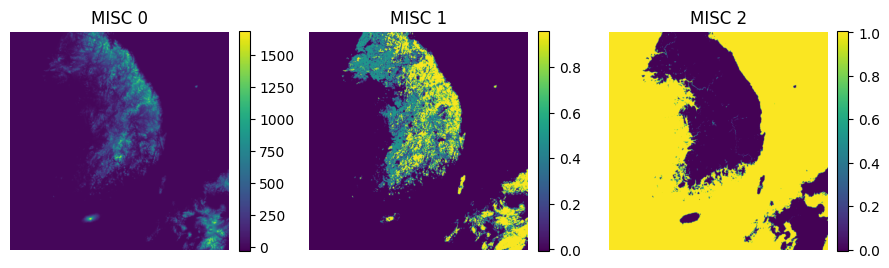

In [6]:
"""
MISC 0: Elevation (고도)
MISC 1: Water Bodies Index (수역 여부)
MISC 2: Vegetation Index (식생 여부)
"""
CROP_BASE = 64  # 512 → 384 crop offset

misc_images = []
for misc_channel, misc_path in misc_channels.items():
    misc_image = np.load(f'assets/misc_channels/{misc_path}', allow_pickle=True)
    # 3600 → 512로 resize 후, 64:448 crop하여 384x384 생성 (위성 이미지와 동일한 영역)
    misc_image = cv2.resize(misc_image, (512, 512), interpolation=cv2.INTER_CUBIC)
    misc_image = misc_image[CROP_BASE:CROP_BASE+image_size, CROP_BASE:CROP_BASE+image_size]
    misc_images.append(misc_image)
misc_images = np.stack(misc_images, axis=0)
misc_images = torch.tensor(misc_images, dtype=torch.float32)

if latlon:
    lat_image = cv2.resize(asos_lat, (asos_image_size, asos_image_size), interpolation=cv2.INTER_CUBIC)
    lon_image = cv2.resize(asos_lon, (asos_image_size, asos_image_size), interpolation=cv2.INTER_CUBIC)
    
    lat_image = torch.tensor(lat_image, dtype=torch.float32).unsqueeze(0)
    lon_image = torch.tensor(lon_image, dtype=torch.float32).unsqueeze(0)
    misc_images = torch.cat([misc_images, lat_image, lon_image], dim=0)

print(f'MISC images shape: {misc_images.shape}')

# normalize by channel
misc_mean = misc_images.mean(dim=[1,2], keepdim=True)
misc_std = misc_images.std(dim=[1,2], keepdim=True)

total_mean = channels_mean + misc_mean.squeeze().tolist()
total_std = channels_std + misc_std.squeeze().tolist()

print(f'Total mean: {total_mean}')
print(f'Total std: {total_std}')

fig, axs = plt.subplots(math.ceil(misc_images.shape[0]/3), 3, figsize=(9, 5))
for i in range(misc_images.shape[0]):
    ax = axs.flatten()[i]
    ax.imshow(misc_images[i].numpy(), cmap='viridis')
    ax.set_title(f'MISC {i}')
    colorbar = plt.colorbar(mappable=ax.images[0], ax=ax, fraction=0.046, pad=0.04)
    ax.axis('off')
for i in range(misc_images.shape[0], len(axs.flatten())):
    ax = axs.flatten()[i]
    ax.axis('off')
plt.tight_layout()
plt.show()

ASOS patch candidates: [[0 0]]


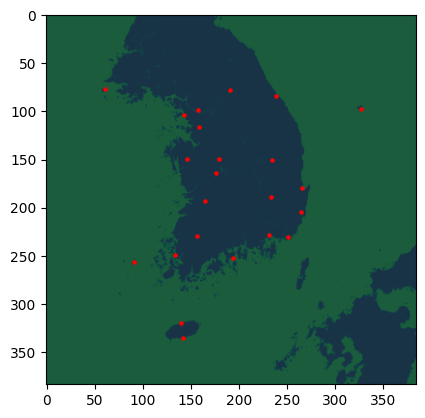

In [7]:
asos_patch_candidate = np.zeros([image_size, image_size], dtype=np.uint8)
for x, y in asos_map_dict.values():
    y_min = np.clip(y - 3*patch_size//4, 0, image_size - patch_size+1)
    y_max = np.clip(y - patch_size//4, 0, image_size - patch_size+1)   
    x_min = np.clip(x - 3*patch_size//4, 0, image_size - patch_size+1)
    x_max = np.clip(x - patch_size//4, 0, image_size - patch_size+1)
    asos_patch_candidate[y_min:y_max, x_min:x_max] = 1
    plt.scatter(x, y, c='r', marker='o', s=5)
plt.imshow(misc_images[2], cmap='viridis', vmin=-1, vmax=2)
plt.imshow(asos_patch_candidate, cmap='gray', vmin=0, vmax=1, alpha=0.5)
asos_patch_candidate = np.argwhere(asos_patch_candidate == 1)[:, [1, 0]]
print(f'ASOS patch candidates: {asos_patch_candidate}')
plt.show()


patch_candidates = {
    'asos': asos_patch_candidate}

In [8]:
transform = transforms.Compose([
    transforms.Normalize(mean=total_mean, std=total_std)
])

train_dataset = GK2ADataset(data_path=data_path, output_path=output_path, data_info_list=train_data_info_list,
                            channels=channels, time_range=time_range, channels_calib=channels_calib, image_size=image_size, misc_images=misc_images,
                            patch_size=patch_size, patch_candidates=patch_candidates, transform=transform, train=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

if ASOS:
    test_asos_dataset = GK2ADataset(data_path=data_path, output_path=output_path, data_info_list=test_asos_data_info_list,
                            channels=channels, time_range=time_range, channels_calib=channels_calib, image_size=image_size, misc_images=misc_images,
                            patch_size=patch_size, patch_candidates=None, transform=transform, train=False)
    test_asos_dataloader = DataLoader(test_asos_dataset, batch_size=batch_size//2, shuffle=False, num_workers=num_workers, drop_last=False)


== Preparing asos...



Processing asos:   1%|▌                                          | 15/1277 [00:00<00:08, 147.26it/s]

  - 20200101 AM skipped, 2019-12-31 12:00:00 not in date_table
  - 20200104 AM skipped, 2020-01-03 12:00:00 not in date_table


Processing asos:  51%|█████████████████████▍                    | 653/1277 [00:02<00:01, 425.18it/s]

  - 20211003 AM skipped, 2021-10-02 12:00:00 not in date_table


Processing asos: 100%|█████████████████████████████████████████| 1277/1277 [00:05<00:00, 237.52it/s]



  - Total 1274 image-label pairs prepared
  - train_asos_image_label_list.yaml saved

== asos dataset length synced to 1274
GK2A Dataset initialized


== Preparing asos...



Processing asos: 100%|███████████████████████████████████████████| 366/366 [00:01<00:00, 239.09it/s]



  - Total 366 image-label pairs prepared
  - test_asos_image_label_list.yaml saved

== asos dataset length synced to 366
GK2A Dataset initialized




In [9]:
# train_dataset.patchfy(True)
# batch = train_dataset[7]
# for i in range(len(batch)):
#     images, label, coords = batch[i]
#     print(images.shape, label.shape, coords.shape)

#     fig, axs = plt.subplots(math.ceil(images.shape[0]/4), 4, figsize=(12, 2.5 * math.ceil(images.shape[0]/4)), subplot_kw={'projection': lcc})
#     for i in range(len(axs.flatten())):
#         ax = axs.flatten()[i]
#         if i >= images.shape[0]:
#             ax.axis('off')
#             continue
        
#         # channel = total_channels[i]
#         # ax.set_title(channel)

#         image = np.ones((asos_image_size, asos_image_size), dtype=np.float32)
#         image *= -1.0
#         image[coords[1]:coords[1]+patch_size, coords[0]:coords[0]+patch_size] = images[i].numpy()

#         ax.set_aspect('equal')
#         ax.axis('off')
        
#         im = ax.pcolormesh(asos_lon, asos_lat, image, cmap='viridis', transform=proj)
            
#         ax.coastlines(resolution='10m', color='black', linewidth=0.5)
#         ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linewidth=0.5)

#         cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
#     plt.tight_layout()
#     plt.show()

In [10]:
model = get_model(total_channels, patch_size, class_num=2, model_type='convlstm')  # 'deeplab', 'convlstm', 'predformer'
model

ConvLSTMSegmentation(
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(115, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (classifier): Conv2d(64, 2, kernel_size=(1, 1), stride=(1, 1))
)

In [11]:
def calc_measure_valid(Y_test, Y_test_hat, cutoff=0.5):
    Y_test = Y_test.ravel()
    Y_test_hat = Y_test_hat.ravel()
    
    Y_valid = (~np.isnan(Y_test))
    Y_test = Y_test[Y_valid]
    Y_test_hat = Y_test_hat[Y_valid]

    cfmat = confusion_matrix(Y_test, Y_test_hat > cutoff, labels = [0,1])
    acc = np.trace(cfmat) / np.sum(cfmat)
    csi = cfmat[1,1] /(np.sum(cfmat) - cfmat[0,0] + 1e-8)
    
    try:
        auroc = roc_auc_score(Y_test, Y_test_hat)
    except Exception as e:
        auroc = 0.0

    return csi, acc, auroc

In [12]:
def train(model, images, labels, coords, map_dict, cls_num=0):
    images = images.cuda()
    labels = labels.cuda()

    pred_map = model.forward(images)[:, cls_num] # B, H, W
    pred_vec = torch.zeros_like(labels)
    for b, (px, py) in enumerate(coords):
        for i, (x, y) in enumerate(map_dict.values()):
            if px <= x < px + patch_size and py <= y < py + patch_size:
                pred_vec[b, i] = pred_map[b, y - py, x - px]
            else:
                pred_vec[b, i] = labels[b, i]

    labels_valid = (~torch.isnan(labels)).float()
    labels = torch.nan_to_num(labels, 0.0)

    loss_focal_raw = sigmoid_focal_loss(pred_vec, labels, alpha=-1, gamma=2, reduction='none')
    loss_focal = (loss_focal_raw * labels_valid).sum() / labels_valid.sum().clamp(min=1.0)
    valid_any_batch = (labels_valid.sum() > 0)
    all_zero_batch = ((labels * labels_valid).sum() == 0)
                
    if not (valid_any_batch and all_zero_batch):
        loss_non_frost = torch.tensor(0.0, device=labels.device)
    else:
        loss_non_frost = binary_cross_entropy_with_logits(
                        pred_map, torch.zeros_like(pred_map), reduction='mean'
                    )

    tp = torch.sum(torch.sigmoid(pred_vec) * labels * labels_valid, dim=0)
    fn = torch.sum((1-torch.sigmoid(pred_vec)) * labels * labels_valid, dim=0)
    fp = torch.sum(torch.sigmoid(pred_vec) * (1-labels) * labels_valid, dim=0)
                
    loss_csi = torch.mean(-torch.log(tp + 1e-10) + torch.log(tp + fn + fp + 1e-10)) # csi = tp / (tp + fn + fp)

    return loss_focal + loss_non_frost + loss_csi
    

for seed in seeds:
    if os.path.exists(f'{output_path}/{seed}/ckpt.pt'):
        print(f'Seed {seed} already done. Skipping...')
        continue

    print(f'--- Seed {seed} ---')
    
    model = get_model(total_channels, patch_size)
    model.cuda()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=decay, gamma=lr_decay)

    start_epoch = 0
    
    results = dict(
            loss = {'asos': [], 'aafos': [], 'total': []},
            csi = {'asos': {}, 'aafos': {}},
            acc = {'asos': {}, 'aafos': {}},
            auroc = {'asos': [], 'aafos': []}, 
            
            best_asos = {},
            best_aafos = {},
            best_mean = {},
        )
    
    for cutoff_str in threshold:
        cutoff_str = str(cutoff_str)
        
        results['csi']['asos'][cutoff_str] = []
        results['acc']['asos'][cutoff_str] = []
        results['best_asos'][cutoff_str] = {'csi': 0.0, 'epoch': -1, 'model': None}
        
        results['csi']['aafos'][cutoff_str] = []
        results['acc']['aafos'][cutoff_str] = []
        results['best_aafos'][cutoff_str] = {'csi': 0.0, 'epoch': -1, 'model': None}
        
        results['best_mean'][cutoff_str] = {'csi': 0.0, 'epoch': -1, 'model': None}
    
    if os.path.exists(f'{output_path}/{seed}/resume.pt'):
        resume = torch.load(f'{output_path}/{seed}/resume.pt')
        model.load_state_dict(resume['model'])
        optimizer.load_state_dict(resume['optimizer'])
        scheduler.load_state_dict(resume['scheduler'])
        start_epoch = resume['epoch'] + 1
        results = resume['results']
        print(f'Resuming from epoch {start_epoch}...')
    
    for epoch in range(start_epoch, epochs):
        model.train()
        
        total_loss_asos = 0.0
        total_loss_aafos = 0.0
        total_loss = 0.0
                
        # asos와 aafos 데이터셋 간 길이 맞춤 / 매 epoch마다 실행
        train_dataset.sync_dataset_length()
        for batch in tqdm(train_dataloader):
            if ASOS:
                images, label, coords = batch[0]
                loss_asos = train(model, images, label, coords, asos_map_dict, cls_num=0)
            else:
                loss_asos = torch.tensor(0.0).cuda()
            
            if AAFOS:
                images, label, coords = batch[1] if ASOS else batch[0]
                loss_aafos = train(model, images, label, coords, aafos_map_dict, cls_num=1)
            else:
                loss_aafos = torch.tensor(0.0).cuda()

            loss = asos_weight * loss_asos + aafos_weight * loss_aafos
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss_asos += loss_asos.item()
            total_loss_aafos += loss_aafos.item()
            total_loss += loss.item()

        total_loss_asos = total_loss_asos / len(train_dataloader)
        total_loss_aafos = total_loss_aafos / len(train_dataloader)
        total_loss = total_loss / len(train_dataloader)

        results['loss']['asos'].append(total_loss_asos)
        results['loss']['aafos'].append(total_loss_aafos)
        results['loss']['total'].append(total_loss)

        print(f'Epoch {epoch+1:2d} - Total Loss: {total_loss:.4f}, ASOS Loss: {total_loss_asos:.4f}, AAFOS Loss: {total_loss_aafos:.4f}')
        # epoch loop에 있으니까 -> 10, 20 epoch마다 lr decay
        scheduler.step()
    
        model.eval()
        with torch.no_grad():
            asos_results_per_threshold = {}
            
            if ASOS:
                asos_pred_vec_list = []
                asos_labels_list = []
                for batch in test_asos_dataloader:
                    images, label, coords = batch[0]
                    images = images.cuda()
                    
                    pred_map = model.forward_by_patch(images)[:,0]
                    pred_map = F.sigmoid(pred_map)
                    
                    pred_vec = []
                    for x, y in asos_map_dict.values():
                        pred_vec.append(pred_map[:, y, x])
                    pred_vec = torch.stack(pred_vec, dim=1)
                    
                    asos_pred_vec_list.append(pred_vec.cpu().numpy())
                    asos_labels_list.append(label.numpy())
                    
                pred_vecs = np.concatenate(asos_pred_vec_list, axis=0)
                labels = np.concatenate(asos_labels_list, axis=0)
                
                for cutoff in threshold:
                    asos_result = calc_measure_valid(labels, pred_vecs, cutoff=cutoff)
                    csi, acc, auroc = asos_result[0], asos_result[1], asos_result[2]

                    cutoff_str = str(cutoff)
                    
                    results['csi']['asos'][cutoff_str].append(csi)
                    results['acc']['asos'][cutoff_str].append(acc)
                    
                    asos_results_per_threshold[cutoff_str] = asos_result
                    
                    is_best = csi > results['best_asos'][cutoff_str]['csi']
                    print(f'\t - ASOS  (T={cutoff:.2f}): CSI {csi:.4f}, AUROC {auroc:.4f} {"*" if is_best else ""}')
                    
                    if is_best:
                        results['best_asos'][cutoff_str]['csi'] = csi
                        results['best_asos'][cutoff_str]['epoch'] = epoch
                        results['best_asos'][cutoff_str]['model'] = model.state_dict()

                    asos_land_result = calc_measure_valid(labels[:,:11], pred_vecs[:,:11], cutoff=cutoff)
                    asos_coast_result = calc_measure_valid(labels[:,11:], pred_vecs[:,11:], cutoff=cutoff)
                    print(f'\t   - ASOS Land: CSI {asos_land_result[0]:.4f}, AUROC {asos_land_result[2]:.4f}')
                    print(f'\t   - ASOS Coast: CSI {asos_coast_result[0]:.4f}, AUROC {asos_coast_result[2]:.4f}')
                        
                results['auroc']['asos'].append(auroc)
                            
            print()
        
        resume = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'epoch': epoch,
            'results': results
        }
        os.makedirs(f'{output_path}/{seed}', exist_ok=True)
        torch.save(resume, f'{output_path}/{seed}/resume.pt')
    
    torch.save(results, f'{output_path}/{seed}/ckpt.pt')
    os.remove(f'{output_path}/{seed}/resume.pt')

Seed 1 already done. Skipping...
--- Seed 2 ---
== asos dataset length synced to 1274


100%|██████████| 39/39 [01:46<00:00,  2.74s/it]

Epoch  1 - Total Loss: 6.2011, ASOS Loss: 6.2011, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4714, AUROC 0.9332 *
	   - ASOS Land: CSI 0.5356, AUROC 0.9277
	   - ASOS Coast: CSI 0.2901, AUROC 0.9073

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.81s/it]

Epoch  2 - Total Loss: 4.9794, ASOS Loss: 4.9794, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.3827, AUROC 0.9336 
	   - ASOS Land: CSI 0.4240, AUROC 0.9397
	   - ASOS Coast: CSI 0.2565, AUROC 0.8900

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.80s/it]

Epoch  3 - Total Loss: 4.8170, ASOS Loss: 4.8170, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4897, AUROC 0.9296 *
	   - ASOS Land: CSI 0.5526, AUROC 0.9358
	   - ASOS Coast: CSI 0.2803, AUROC 0.8797

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.82s/it]

Epoch  4 - Total Loss: 4.4426, ASOS Loss: 4.4426, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4905, AUROC 0.9353 *
	   - ASOS Land: CSI 0.5618, AUROC 0.9413
	   - ASOS Coast: CSI 0.3042, AUROC 0.8914

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.81s/it]

Epoch  5 - Total Loss: 4.0679, ASOS Loss: 4.0679, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4914, AUROC 0.9337 *
	   - ASOS Land: CSI 0.5519, AUROC 0.9414
	   - ASOS Coast: CSI 0.2901, AUROC 0.8793

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.81s/it]

Epoch  6 - Total Loss: 3.9685, ASOS Loss: 3.9685, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5159, AUROC 0.9461 *
	   - ASOS Land: CSI 0.5875, AUROC 0.9514
	   - ASOS Coast: CSI 0.3444, AUROC 0.9085

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.81s/it]

Epoch  7 - Total Loss: 3.8185, ASOS Loss: 3.8185, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4403, AUROC 0.9347 
	   - ASOS Land: CSI 0.4813, AUROC 0.9338
	   - ASOS Coast: CSI 0.3154, AUROC 0.8993

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.81s/it]

Epoch  8 - Total Loss: 4.0012, ASOS Loss: 4.0012, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4897, AUROC 0.9394 
	   - ASOS Land: CSI 0.5431, AUROC 0.9466
	   - ASOS Coast: CSI 0.3209, AUROC 0.8943

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.82s/it]

Epoch  9 - Total Loss: 3.7496, ASOS Loss: 3.7496, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5353, AUROC 0.9448 *
	   - ASOS Land: CSI 0.5913, AUROC 0.9533
	   - ASOS Coast: CSI 0.3629, AUROC 0.9047

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.81s/it]

Epoch 10 - Total Loss: 3.9028, ASOS Loss: 3.9028, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4680, AUROC 0.9309 
	   - ASOS Land: CSI 0.5229, AUROC 0.9391
	   - ASOS Coast: CSI 0.3218, AUROC 0.8833

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.81s/it]

Epoch 11 - Total Loss: 3.4254, ASOS Loss: 3.4254, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4997, AUROC 0.9443 
	   - ASOS Land: CSI 0.5500, AUROC 0.9516
	   - ASOS Coast: CSI 0.3548, AUROC 0.9038

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.80s/it]

Epoch 12 - Total Loss: 3.9156, ASOS Loss: 3.9156, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5322, AUROC 0.9461 
	   - ASOS Land: CSI 0.5871, AUROC 0.9546
	   - ASOS Coast: CSI 0.3664, AUROC 0.9051

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.81s/it]

Epoch 13 - Total Loss: 3.7151, ASOS Loss: 3.7151, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5235, AUROC 0.9474 
	   - ASOS Land: CSI 0.5776, AUROC 0.9565
	   - ASOS Coast: CSI 0.3568, AUROC 0.9077

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.82s/it]

Epoch 14 - Total Loss: 4.0169, ASOS Loss: 4.0169, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5274, AUROC 0.9463 
	   - ASOS Land: CSI 0.5915, AUROC 0.9562
	   - ASOS Coast: CSI 0.3194, AUROC 0.9055

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.81s/it]

Epoch 15 - Total Loss: 3.6869, ASOS Loss: 3.6869, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5029, AUROC 0.9465 
	   - ASOS Land: CSI 0.5656, AUROC 0.9566
	   - ASOS Coast: CSI 0.3138, AUROC 0.9071

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.81s/it]

Epoch 16 - Total Loss: 3.6065, ASOS Loss: 3.6065, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5321, AUROC 0.9471 
	   - ASOS Land: CSI 0.5919, AUROC 0.9564
	   - ASOS Coast: CSI 0.3598, AUROC 0.9084

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.81s/it]

Epoch 17 - Total Loss: 3.5449, ASOS Loss: 3.5449, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5251, AUROC 0.9475 
	   - ASOS Land: CSI 0.5825, AUROC 0.9569
	   - ASOS Coast: CSI 0.3499, AUROC 0.9078

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.81s/it]

Epoch 18 - Total Loss: 3.4658, ASOS Loss: 3.4658, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5295, AUROC 0.9454 
	   - ASOS Land: CSI 0.6041, AUROC 0.9553
	   - ASOS Coast: CSI 0.3148, AUROC 0.9032

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.82s/it]

Epoch 19 - Total Loss: 3.7764, ASOS Loss: 3.7764, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5277, AUROC 0.9461 
	   - ASOS Land: CSI 0.5972, AUROC 0.9570
	   - ASOS Coast: CSI 0.3130, AUROC 0.9032

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.81s/it]

Epoch 20 - Total Loss: 3.7056, ASOS Loss: 3.7056, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5329, AUROC 0.9452 
	   - ASOS Land: CSI 0.6033, AUROC 0.9553
	   - ASOS Coast: CSI 0.3296, AUROC 0.9049

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.81s/it]

Epoch 21 - Total Loss: 3.6718, ASOS Loss: 3.6718, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5302, AUROC 0.9460 
	   - ASOS Land: CSI 0.5989, AUROC 0.9569
	   - ASOS Coast: CSI 0.3249, AUROC 0.9053

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.82s/it]

Epoch 22 - Total Loss: 3.5614, ASOS Loss: 3.5614, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5275, AUROC 0.9452 
	   - ASOS Land: CSI 0.5943, AUROC 0.9557
	   - ASOS Coast: CSI 0.3237, AUROC 0.9042

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.82s/it]

Epoch 23 - Total Loss: 3.5334, ASOS Loss: 3.5334, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5296, AUROC 0.9450 
	   - ASOS Land: CSI 0.5968, AUROC 0.9553
	   - ASOS Coast: CSI 0.3256, AUROC 0.9043

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.81s/it]

Epoch 24 - Total Loss: 3.4843, ASOS Loss: 3.4843, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5292, AUROC 0.9454 
	   - ASOS Land: CSI 0.5949, AUROC 0.9560
	   - ASOS Coast: CSI 0.3286, AUROC 0.9050

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.81s/it]

Epoch 25 - Total Loss: 3.6940, ASOS Loss: 3.6940, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5298, AUROC 0.9458 
	   - ASOS Land: CSI 0.5988, AUROC 0.9561
	   - ASOS Coast: CSI 0.3174, AUROC 0.9059

--- Seed 3 ---
== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.74s/it]

Epoch  1 - Total Loss: 6.5062, ASOS Loss: 6.5062, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4384, AUROC 0.9085 *
	   - ASOS Land: CSI 0.5092, AUROC 0.9164
	   - ASOS Coast: CSI 0.2118, AUROC 0.8525

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:46<00:00,  2.74s/it]

Epoch  2 - Total Loss: 4.6699, ASOS Loss: 4.6699, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4572, AUROC 0.9265 *
	   - ASOS Land: CSI 0.5278, AUROC 0.9352
	   - ASOS Coast: CSI 0.2594, AUROC 0.8705

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch  3 - Total Loss: 4.6547, ASOS Loss: 4.6547, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4304, AUROC 0.9380 
	   - ASOS Land: CSI 0.5015, AUROC 0.9377
	   - ASOS Coast: CSI 0.2712, AUROC 0.9055

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch  4 - Total Loss: 4.4437, ASOS Loss: 4.4437, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4761, AUROC 0.9352 *
	   - ASOS Land: CSI 0.5379, AUROC 0.9369
	   - ASOS Coast: CSI 0.3189, AUROC 0.8978

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:46<00:00,  2.74s/it]

Epoch  5 - Total Loss: 4.2515, ASOS Loss: 4.2515, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4857, AUROC 0.9409 *
	   - ASOS Land: CSI 0.5378, AUROC 0.9505
	   - ASOS Coast: CSI 0.3070, AUROC 0.8966

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:46<00:00,  2.74s/it]

Epoch  6 - Total Loss: 3.9885, ASOS Loss: 3.9885, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4809, AUROC 0.9339 
	   - ASOS Land: CSI 0.5499, AUROC 0.9338
	   - ASOS Coast: CSI 0.3171, AUROC 0.9015

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:46<00:00,  2.74s/it]

Epoch  7 - Total Loss: 3.7455, ASOS Loss: 3.7455, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5105, AUROC 0.9461 *
	   - ASOS Land: CSI 0.5616, AUROC 0.9520
	   - ASOS Coast: CSI 0.3522, AUROC 0.9066

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch  8 - Total Loss: 3.7608, ASOS Loss: 3.7608, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5075, AUROC 0.9415 
	   - ASOS Land: CSI 0.5673, AUROC 0.9493
	   - ASOS Coast: CSI 0.3324, AUROC 0.8987

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:46<00:00,  2.74s/it]

Epoch  9 - Total Loss: 3.7879, ASOS Loss: 3.7879, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5296, AUROC 0.9405 *
	   - ASOS Land: CSI 0.5958, AUROC 0.9451
	   - ASOS Coast: CSI 0.3468, AUROC 0.9003

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch 10 - Total Loss: 4.0092, ASOS Loss: 4.0092, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4986, AUROC 0.9396 
	   - ASOS Land: CSI 0.5629, AUROC 0.9459
	   - ASOS Coast: CSI 0.3166, AUROC 0.8978

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch 11 - Total Loss: 3.7920, ASOS Loss: 3.7920, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5023, AUROC 0.9427 
	   - ASOS Land: CSI 0.5643, AUROC 0.9501
	   - ASOS Coast: CSI 0.3250, AUROC 0.8997

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch 12 - Total Loss: 3.5728, ASOS Loss: 3.5728, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5258, AUROC 0.9448 
	   - ASOS Land: CSI 0.5878, AUROC 0.9541
	   - ASOS Coast: CSI 0.3442, AUROC 0.9002

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:46<00:00,  2.74s/it]

Epoch 13 - Total Loss: 3.8349, ASOS Loss: 3.8349, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5192, AUROC 0.9471 
	   - ASOS Land: CSI 0.5818, AUROC 0.9563
	   - ASOS Coast: CSI 0.3368, AUROC 0.9040

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch 14 - Total Loss: 3.6055, ASOS Loss: 3.6055, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5222, AUROC 0.9473 
	   - ASOS Land: CSI 0.5826, AUROC 0.9574
	   - ASOS Coast: CSI 0.3397, AUROC 0.9031

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.74s/it]

Epoch 15 - Total Loss: 3.5838, ASOS Loss: 3.5838, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5219, AUROC 0.9472 
	   - ASOS Land: CSI 0.5844, AUROC 0.9567
	   - ASOS Coast: CSI 0.3378, AUROC 0.9044

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.74s/it]

Epoch 16 - Total Loss: 3.6926, ASOS Loss: 3.6926, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5302, AUROC 0.9467 *
	   - ASOS Land: CSI 0.5888, AUROC 0.9569
	   - ASOS Coast: CSI 0.3442, AUROC 0.9034

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:46<00:00,  2.74s/it]

Epoch 17 - Total Loss: 3.4037, ASOS Loss: 3.4037, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5260, AUROC 0.9458 
	   - ASOS Land: CSI 0.5836, AUROC 0.9555
	   - ASOS Coast: CSI 0.3460, AUROC 0.9020

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:46<00:00,  2.74s/it]

Epoch 18 - Total Loss: 3.4074, ASOS Loss: 3.4074, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5203, AUROC 0.9470 
	   - ASOS Land: CSI 0.5803, AUROC 0.9574
	   - ASOS Coast: CSI 0.3274, AUROC 0.9023

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch 19 - Total Loss: 3.5424, ASOS Loss: 3.5424, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5212, AUROC 0.9465 
	   - ASOS Land: CSI 0.5820, AUROC 0.9574
	   - ASOS Coast: CSI 0.3274, AUROC 0.9019

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch 20 - Total Loss: 3.4470, ASOS Loss: 3.4470, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5200, AUROC 0.9468 
	   - ASOS Land: CSI 0.5851, AUROC 0.9574
	   - ASOS Coast: CSI 0.3200, AUROC 0.9022

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch 21 - Total Loss: 3.3064, ASOS Loss: 3.3064, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5189, AUROC 0.9469 
	   - ASOS Land: CSI 0.5808, AUROC 0.9578
	   - ASOS Coast: CSI 0.3268, AUROC 0.9018

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.76s/it]

Epoch 22 - Total Loss: 3.2287, ASOS Loss: 3.2287, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5196, AUROC 0.9471 
	   - ASOS Land: CSI 0.5843, AUROC 0.9578
	   - ASOS Coast: CSI 0.3212, AUROC 0.9023

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch 23 - Total Loss: 3.2944, ASOS Loss: 3.2944, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5211, AUROC 0.9474 
	   - ASOS Land: CSI 0.5833, AUROC 0.9582
	   - ASOS Coast: CSI 0.3296, AUROC 0.9027

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch 24 - Total Loss: 3.2843, ASOS Loss: 3.2843, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5190, AUROC 0.9472 
	   - ASOS Land: CSI 0.5782, AUROC 0.9581
	   - ASOS Coast: CSI 0.3379, AUROC 0.9027

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:48<00:00,  2.77s/it]

Epoch 25 - Total Loss: 3.6259, ASOS Loss: 3.6259, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5202, AUROC 0.9469 
	   - ASOS Land: CSI 0.5860, AUROC 0.9578
	   - ASOS Coast: CSI 0.3202, AUROC 0.9024

--- Seed 4 ---
== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.76s/it]

Epoch  1 - Total Loss: 6.0641, ASOS Loss: 6.0641, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4151, AUROC 0.9247 *
	   - ASOS Land: CSI 0.4752, AUROC 0.9221
	   - ASOS Coast: CSI 0.2530, AUROC 0.8834

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:46<00:00,  2.74s/it]

Epoch  2 - Total Loss: 4.4871, ASOS Loss: 4.4871, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4698, AUROC 0.9382 *
	   - ASOS Land: CSI 0.5371, AUROC 0.9414
	   - ASOS Coast: CSI 0.3004, AUROC 0.9015

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch  3 - Total Loss: 4.5544, ASOS Loss: 4.5544, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4827, AUROC 0.9276 *
	   - ASOS Land: CSI 0.5391, AUROC 0.9385
	   - ASOS Coast: CSI 0.2891, AUROC 0.8783

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch  4 - Total Loss: 4.1950, ASOS Loss: 4.1950, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4192, AUROC 0.9233 
	   - ASOS Land: CSI 0.4778, AUROC 0.9211
	   - ASOS Coast: CSI 0.2738, AUROC 0.8925

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.76s/it]

Epoch  5 - Total Loss: 4.5376, ASOS Loss: 4.5376, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4767, AUROC 0.9142 
	   - ASOS Land: CSI 0.5399, AUROC 0.9205
	   - ASOS Coast: CSI 0.2539, AUROC 0.8668

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch  6 - Total Loss: 3.8674, ASOS Loss: 3.8674, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4989, AUROC 0.9382 *
	   - ASOS Land: CSI 0.5616, AUROC 0.9436
	   - ASOS Coast: CSI 0.2962, AUROC 0.9015

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch  7 - Total Loss: 3.6287, ASOS Loss: 3.6287, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4776, AUROC 0.9284 
	   - ASOS Land: CSI 0.5472, AUROC 0.9338
	   - ASOS Coast: CSI 0.3029, AUROC 0.8921

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.74s/it]

Epoch  8 - Total Loss: 3.8112, ASOS Loss: 3.8112, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4348, AUROC 0.9350 
	   - ASOS Land: CSI 0.4959, AUROC 0.9341
	   - ASOS Coast: CSI 0.2885, AUROC 0.9038

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch  9 - Total Loss: 3.7048, ASOS Loss: 3.7048, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4787, AUROC 0.9333 
	   - ASOS Land: CSI 0.5358, AUROC 0.9436
	   - ASOS Coast: CSI 0.3141, AUROC 0.8894

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch 10 - Total Loss: 3.6391, ASOS Loss: 3.6391, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4868, AUROC 0.9392 
	   - ASOS Land: CSI 0.5413, AUROC 0.9434
	   - ASOS Coast: CSI 0.3432, AUROC 0.9046

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch 11 - Total Loss: 3.7016, ASOS Loss: 3.7016, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5046, AUROC 0.9424 *
	   - ASOS Land: CSI 0.5662, AUROC 0.9499
	   - ASOS Coast: CSI 0.3397, AUROC 0.9024

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.77s/it]

Epoch 12 - Total Loss: 3.7436, ASOS Loss: 3.7436, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5196, AUROC 0.9443 *
	   - ASOS Land: CSI 0.5798, AUROC 0.9523
	   - ASOS Coast: CSI 0.3467, AUROC 0.9038

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.76s/it]

Epoch 13 - Total Loss: 3.8008, ASOS Loss: 3.8008, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5225, AUROC 0.9449 *
	   - ASOS Land: CSI 0.5820, AUROC 0.9534
	   - ASOS Coast: CSI 0.3501, AUROC 0.9066

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch 14 - Total Loss: 3.6565, ASOS Loss: 3.6565, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5289, AUROC 0.9448 *
	   - ASOS Land: CSI 0.5897, AUROC 0.9541
	   - ASOS Coast: CSI 0.3493, AUROC 0.9041

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:46<00:00,  2.74s/it]

Epoch 15 - Total Loss: 3.6117, ASOS Loss: 3.6117, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5209, AUROC 0.9458 
	   - ASOS Land: CSI 0.5805, AUROC 0.9554
	   - ASOS Coast: CSI 0.3457, AUROC 0.9045

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:46<00:00,  2.74s/it]

Epoch 16 - Total Loss: 3.8827, ASOS Loss: 3.8827, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5281, AUROC 0.9469 
	   - ASOS Land: CSI 0.5884, AUROC 0.9565
	   - ASOS Coast: CSI 0.3529, AUROC 0.9078

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:46<00:00,  2.74s/it]

Epoch 17 - Total Loss: 3.8138, ASOS Loss: 3.8138, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5226, AUROC 0.9466 
	   - ASOS Land: CSI 0.5830, AUROC 0.9564
	   - ASOS Coast: CSI 0.3440, AUROC 0.9065

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:46<00:00,  2.74s/it]

Epoch 18 - Total Loss: 3.8352, ASOS Loss: 3.8352, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5201, AUROC 0.9463 
	   - ASOS Land: CSI 0.5782, AUROC 0.9567
	   - ASOS Coast: CSI 0.3431, AUROC 0.9042

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:46<00:00,  2.74s/it]

Epoch 19 - Total Loss: 3.4581, ASOS Loss: 3.4581, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5210, AUROC 0.9468 
	   - ASOS Land: CSI 0.5760, AUROC 0.9565
	   - ASOS Coast: CSI 0.3548, AUROC 0.9075

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.74s/it]

Epoch 20 - Total Loss: 3.3708, ASOS Loss: 3.3708, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5374, AUROC 0.9460 *
	   - ASOS Land: CSI 0.6066, AUROC 0.9570
	   - ASOS Coast: CSI 0.3323, AUROC 0.9032

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.74s/it]

Epoch 21 - Total Loss: 3.5995, ASOS Loss: 3.5995, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5297, AUROC 0.9468 
	   - ASOS Land: CSI 0.5882, AUROC 0.9577
	   - ASOS Coast: CSI 0.3569, AUROC 0.9054

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch 22 - Total Loss: 3.3512, ASOS Loss: 3.3512, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5303, AUROC 0.9469 
	   - ASOS Land: CSI 0.5902, AUROC 0.9577
	   - ASOS Coast: CSI 0.3558, AUROC 0.9055

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.74s/it]

Epoch 23 - Total Loss: 3.9194, ASOS Loss: 3.9194, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5301, AUROC 0.9466 
	   - ASOS Land: CSI 0.5900, AUROC 0.9575
	   - ASOS Coast: CSI 0.3494, AUROC 0.9047

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.74s/it]

Epoch 24 - Total Loss: 3.6277, ASOS Loss: 3.6277, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5341, AUROC 0.9465 
	   - ASOS Land: CSI 0.5960, AUROC 0.9575
	   - ASOS Coast: CSI 0.3477, AUROC 0.9045

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch 25 - Total Loss: 3.2848, ASOS Loss: 3.2848, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5314, AUROC 0.9468 
	   - ASOS Land: CSI 0.5921, AUROC 0.9577
	   - ASOS Coast: CSI 0.3476, AUROC 0.9050

--- Seed 5 ---
== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch  1 - Total Loss: 5.9785, ASOS Loss: 5.9785, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4234, AUROC 0.9156 *
	   - ASOS Land: CSI 0.4770, AUROC 0.9203
	   - ASOS Coast: CSI 0.2337, AUROC 0.8631

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch  2 - Total Loss: 4.8839, ASOS Loss: 4.8839, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4606, AUROC 0.9238 *
	   - ASOS Land: CSI 0.5094, AUROC 0.9296
	   - ASOS Coast: CSI 0.2989, AUROC 0.8744

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.76s/it]

Epoch  3 - Total Loss: 4.3087, ASOS Loss: 4.3087, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4179, AUROC 0.9239 
	   - ASOS Land: CSI 0.4630, AUROC 0.9276
	   - ASOS Coast: CSI 0.2733, AUROC 0.8745

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch  4 - Total Loss: 4.0470, ASOS Loss: 4.0470, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4328, AUROC 0.9300 
	   - ASOS Land: CSI 0.4950, AUROC 0.9286
	   - ASOS Coast: CSI 0.2883, AUROC 0.8918

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch  5 - Total Loss: 3.7269, ASOS Loss: 3.7269, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4319, AUROC 0.9297 
	   - ASOS Land: CSI 0.4815, AUROC 0.9243
	   - ASOS Coast: CSI 0.2961, AUROC 0.8992

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch  6 - Total Loss: 3.8262, ASOS Loss: 3.8262, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4169, AUROC 0.9247 
	   - ASOS Land: CSI 0.4823, AUROC 0.9174
	   - ASOS Coast: CSI 0.2393, AUROC 0.8908

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch  7 - Total Loss: 4.1844, ASOS Loss: 4.1844, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.3961, AUROC 0.9202 
	   - ASOS Land: CSI 0.4395, AUROC 0.9202
	   - ASOS Coast: CSI 0.2652, AUROC 0.8799

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch  8 - Total Loss: 3.9740, ASOS Loss: 3.9740, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5163, AUROC 0.9365 *
	   - ASOS Land: CSI 0.5902, AUROC 0.9472
	   - ASOS Coast: CSI 0.2958, AUROC 0.8914

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch  9 - Total Loss: 3.9625, ASOS Loss: 3.9625, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4861, AUROC 0.9436 
	   - ASOS Land: CSI 0.5391, AUROC 0.9508
	   - ASOS Coast: CSI 0.3269, AUROC 0.9041

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch 10 - Total Loss: 3.7476, ASOS Loss: 3.7476, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5337, AUROC 0.9480 *
	   - ASOS Land: CSI 0.5989, AUROC 0.9548
	   - ASOS Coast: CSI 0.3570, AUROC 0.9074

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.76s/it]

Epoch 11 - Total Loss: 3.6607, ASOS Loss: 3.6607, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5210, AUROC 0.9491 
	   - ASOS Land: CSI 0.5842, AUROC 0.9566
	   - ASOS Coast: CSI 0.3501, AUROC 0.9082

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch 12 - Total Loss: 3.6315, ASOS Loss: 3.6315, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5250, AUROC 0.9497 
	   - ASOS Land: CSI 0.5862, AUROC 0.9573
	   - ASOS Coast: CSI 0.3554, AUROC 0.9093

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.76s/it]

Epoch 13 - Total Loss: 3.6511, ASOS Loss: 3.6511, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5320, AUROC 0.9491 
	   - ASOS Land: CSI 0.5885, AUROC 0.9567
	   - ASOS Coast: CSI 0.3728, AUROC 0.9095

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.76s/it]

Epoch 14 - Total Loss: 3.5737, ASOS Loss: 3.5737, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5348, AUROC 0.9486 *
	   - ASOS Land: CSI 0.5935, AUROC 0.9572
	   - ASOS Coast: CSI 0.3499, AUROC 0.9066

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:47<00:00,  2.75s/it]

Epoch 15 - Total Loss: 3.5620, ASOS Loss: 3.5620, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5330, AUROC 0.9482 
	   - ASOS Land: CSI 0.5860, AUROC 0.9564
	   - ASOS Coast: CSI 0.3760, AUROC 0.9080

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:48<00:00,  2.78s/it]

Epoch 16 - Total Loss: 3.4016, ASOS Loss: 3.4016, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5424, AUROC 0.9476 *
	   - ASOS Land: CSI 0.6046, AUROC 0.9564
	   - ASOS Coast: CSI 0.3536, AUROC 0.9061

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.81s/it]

Epoch 17 - Total Loss: 3.5944, ASOS Loss: 3.5944, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5306, AUROC 0.9468 
	   - ASOS Land: CSI 0.5889, AUROC 0.9550
	   - ASOS Coast: CSI 0.3483, AUROC 0.9056

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.81s/it]

Epoch 18 - Total Loss: 3.5566, ASOS Loss: 3.5566, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5464, AUROC 0.9471 *
	   - ASOS Land: CSI 0.6087, AUROC 0.9562
	   - ASOS Coast: CSI 0.3610, AUROC 0.9061

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.82s/it]

Epoch 19 - Total Loss: 3.4976, ASOS Loss: 3.4976, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5350, AUROC 0.9468 
	   - ASOS Land: CSI 0.5962, AUROC 0.9555
	   - ASOS Coast: CSI 0.3556, AUROC 0.9058

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.82s/it]

Epoch 20 - Total Loss: 3.4419, ASOS Loss: 3.4419, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5388, AUROC 0.9467 
	   - ASOS Land: CSI 0.5953, AUROC 0.9567
	   - ASOS Coast: CSI 0.3609, AUROC 0.9039

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:50<00:00,  2.82s/it]

Epoch 21 - Total Loss: 3.8800, ASOS Loss: 3.8800, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5375, AUROC 0.9461 
	   - ASOS Land: CSI 0.5959, AUROC 0.9565
	   - ASOS Coast: CSI 0.3555, AUROC 0.9026

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.81s/it]

Epoch 22 - Total Loss: 3.6412, ASOS Loss: 3.6412, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5464, AUROC 0.9463 
	   - ASOS Land: CSI 0.6062, AUROC 0.9565
	   - ASOS Coast: CSI 0.3540, AUROC 0.9033

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.82s/it]

Epoch 23 - Total Loss: 3.4987, ASOS Loss: 3.4987, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5425, AUROC 0.9462 
	   - ASOS Land: CSI 0.6006, AUROC 0.9564
	   - ASOS Coast: CSI 0.3556, AUROC 0.9033

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.82s/it]

Epoch 24 - Total Loss: 3.6292, ASOS Loss: 3.6292, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5316, AUROC 0.9465 
	   - ASOS Land: CSI 0.5914, AUROC 0.9567
	   - ASOS Coast: CSI 0.3466, AUROC 0.9039

== asos dataset length synced to 1274


100%|██████████| 39/39 [01:49<00:00,  2.80s/it]

Epoch 25 - Total Loss: 3.3287, ASOS Loss: 3.3287, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5395, AUROC 0.9467 
	   - ASOS Land: CSI 0.5978, AUROC 0.9567
	   - ASOS Coast: CSI 0.3567, AUROC 0.9041



In [13]:
if ASOS and not AAFOS:
    mode = 'best_asos'

results_df = pd.DataFrame(columns=['type','cutoff','label', 'csi', 'acc', 'auroc'])

results_dict = {}
for cutoff in threshold:
    results_dict[str(cutoff)] = {
        'asos': {},
        'aafos': {}
    }

for seed in seeds:
    ckpt_path = f'{output_path}/{seed}/ckpt.pt'
    if not os.path.exists(ckpt_path):
        print(f'Seed {seed} not found. Skipping...')
        continue
    
    ckpt = torch.load(ckpt_path)
    print(f'--- Processing Seed {seed} ({ckpt_path}) ---')

    model = get_model(total_channels, patch_size)
    model.cuda()
    
    for cutoff in threshold:
        cutoff_str = str(cutoff)
        
        if cutoff_str not in ckpt[mode]:
            print(f"  Warning: T={cutoff_str} not found for mode '{mode}' in seed {seed}. Skipping.")
            continue
            
        try:
            model_data = ckpt[mode][cutoff_str]
            model.load_state_dict(model_data['model'])
            model.eval()
            print(f"  T={cutoff_str}: Loaded epoch {model_data['epoch']} with {mode} CSI {model_data['csi']:.4f}")
        except Exception as e:
            print(f"  Error loading model for T={cutoff_str}, Seed={seed}: {e}. Skipping.")
            continue
        
        
        with torch.no_grad():
            if ASOS:
                asos_pred_vec_list = []
                asos_labels_list = []
                
                for batch in tqdm(test_asos_dataloader, desc=f"ASOS Eval (Seed {seed}, T={cutoff_str})"):
                    images, label, coords = batch[0]
                    images = images.cuda()
                    
                    pred_map = model.forward_by_patch(images)[:,0]
                    pred_map = F.sigmoid(pred_map)
                    
                    pred_vec = []
                    for x, y in asos_map_dict.values():
                        pred_vec.append(pred_map[:, y, x])
                    pred_vec = torch.stack(pred_vec, dim=1)
                    
                    asos_pred_vec_list.append(pred_vec.cpu().numpy())
                    asos_labels_list.append(label.numpy())
                        
                pred_vecs = np.concatenate(asos_pred_vec_list, axis=0)
                labels = np.concatenate(asos_labels_list, axis=0)
                
                label_cols = [col for _, col in test_asos_data_info_list[0]['hour_col_pairs']]
                for col in label_cols:
                    indices = [i for i, data_dict in enumerate(test_asos_dataset.data_info_list[0]['data_dict_list']) if data_dict['label_col'] == col]
                    pred_vec_selected = pred_vecs[indices]
                    labels_selected = labels[indices]
                    
                    results = calc_measure_valid(labels_selected, pred_vec_selected, cutoff=cutoff)
                    
                    results_dict[cutoff_str]['asos'].setdefault(col, {})
                    results_dict[cutoff_str]['asos'][col].setdefault('csi', []).append(results[0])
                    results_dict[cutoff_str]['asos'][col].setdefault('acc', []).append(results[1])
                    results_dict[cutoff_str]['asos'][col].setdefault('auroc', []).append(results[2])


all_results_rows = []

for cutoff_str, type_dict_for_thr in results_dict.items():
    for data_type, type_dict in type_dict_for_thr.items():
        csi_mean_list = []
        acc_mean_list = []
        auroc_mean_list = []
        
        for label_col, metrics_dict in type_dict.items():
            
            if not metrics_dict.get('csi'):
                print(f"Warning: No data found for T={cutoff_str}, Type={data_type}, Label={label_col}. Skipping row.")
                continue

            csi_mean = np.mean(metrics_dict['csi'])
            csi_mean_list.append(csi_mean)
            csi_std = np.std(metrics_dict['csi'])
            
            acc_mean = np.mean(metrics_dict['acc']) 
            acc_mean_list.append(acc_mean)
            acc_std = np.std(metrics_dict['acc'])
            
            auroc_mean = np.mean(metrics_dict['auroc'])
            auroc_mean_list.append(auroc_mean)
            auroc_std = np.std(metrics_dict['auroc'])

            all_results_rows.append({
                'type': data_type,
                'threshold': cutoff_str,  
                'label': label_col,
                'csi': f'{csi_mean:.4f}',
                'acc': f'{acc_mean:.4f}',
                'auroc': f'{auroc_mean:.4f}',
            })
            
        all_results_rows.append({
            'type': data_type,
            'threshold': cutoff_str,
            'label': 'mean',
            'csi': f'{np.mean(csi_mean_list):.4f}',
            'acc': f'{np.mean(acc_mean_list):.4f}',
            'auroc': f'{np.mean(auroc_mean_list):.4f}',
        })


if all_results_rows:
    results_df = pd.DataFrame(all_results_rows)
else:
    print("Warning: No results were generated.")
print(results_df) 

output_csv_path = f'{output_path}/final_results_{mode}.csv'
results_df.to_csv(output_csv_path, index=False)
print(f"\nFinal results saved to {output_csv_path}")

--- Processing Seed 1 (results/asos_16ch_time[-18, -15, -12]_2km_convlstm_prediction_384/1/ckpt.pt) ---
  T=0.25: Loaded epoch 11 with best_asos CSI 0.5412


ASOS Eval (Seed 1, T=0.25): 100%|██████████| 23/23 [00:31<00:00,  1.38s/it]


--- Processing Seed 2 (results/asos_16ch_time[-18, -15, -12]_2km_convlstm_prediction_384/2/ckpt.pt) ---
  T=0.25: Loaded epoch 8 with best_asos CSI 0.5353


ASOS Eval (Seed 2, T=0.25): 100%|██████████| 23/23 [00:31<00:00,  1.38s/it]


--- Processing Seed 3 (results/asos_16ch_time[-18, -15, -12]_2km_convlstm_prediction_384/3/ckpt.pt) ---
  T=0.25: Loaded epoch 15 with best_asos CSI 0.5302


ASOS Eval (Seed 3, T=0.25): 100%|██████████| 23/23 [00:31<00:00,  1.38s/it]


--- Processing Seed 4 (results/asos_16ch_time[-18, -15, -12]_2km_convlstm_prediction_384/4/ckpt.pt) ---
  T=0.25: Loaded epoch 19 with best_asos CSI 0.5374


ASOS Eval (Seed 4, T=0.25): 100%|██████████| 23/23 [00:31<00:00,  1.37s/it]


--- Processing Seed 5 (results/asos_16ch_time[-18, -15, -12]_2km_convlstm_prediction_384/5/ckpt.pt) ---
  T=0.25: Loaded epoch 17 with best_asos CSI 0.5464


ASOS Eval (Seed 5, T=0.25): 100%|██████████| 23/23 [00:31<00:00,  1.37s/it]

    type threshold label     csi     acc   auroc
0   asos      0.25    AM  0.5298  0.9210  0.9470
1   asos      0.25  mean  0.5298  0.9210  0.9470
2  aafos      0.25  mean     nan     nan     nan

Final results saved to results/asos_16ch_time[-18, -15, -12]_2km_convlstm_prediction_384/final_results_best_asos.csv



/home/dm4/anaconda3/envs/urp_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dm4/anaconda3/envs/urp_env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [14]:
water_map = np.load('./assets/misc_channels/watermap_1km_avg_1800.npy')
water_map = cv2.resize(water_map, (image_size, image_size), interpolation=cv2.INTER_CUBIC)
water_mask = -1.0 * water_map + 1.0
print(water_mask.shape)

(384, 384)
